# X_wt_tag shape fit

**Motivation:** In the last iteration of the analysis, Patrick used the background estimate derived w/o the $X_{Wt}$ cut, but then looked at 2 bins for the all-had enriched and the QCD enriched variables with a boundary value of 0.75 (i.e, below the $X_{wt}$ = 1.5 cut boundary).

However, there is quite a bit more information in the full $X_{wt}$ distribution, so I'm going to try to make use of it right now to get _more stable_ SFs for these fits.

For completeness, this is the 4b fit table that I made before (it's in my slide deck titled: ggF_PUSH_6_14_21).

<img src="figures/firstFits4b.png">

**What are we looking for?** 
- That we have roughly stable SFs for each physics sample across the years.
- Even more importantly, that we can have mostly consistent results b/w the CR and VR.
- We really care about pinning down the QCD normalization since this will drive our sensitivity.




Cool beans, I had popped most of my code into Sean's `non-resonant-studies` folder alreadfy!!

In [260]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

from scipy.optimize import curve_fit

import os
              
dirname = '../../hh4b/hh4b-plots/hh4b_plots/'
os.sys.path+= [dirname,'../non-resonant-studies/']

from lim_utils import lumi as L 
from utils import systs, calc_bstrap, get_wlab, cat_sel
from utils import enrichedRegions, f, getFit
import pyhf

plt.style.use(os.path.join(dirname, 'stylesheets/ATLAS.mplstyle'))

from colors import *
from phys_utils import target_to_label

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Set up tables**

In [84]:
yrs = [16,17,18]
mcs = ['a','d','e']
bcat='4b'

In [277]:
idx = ['CR SF','VR SF','extrap norm (new)']
cols = pd.MultiIndex.from_product([[16, 17, 18],['semi-lep','all-had','QCD']])

sfs = pd.DataFrame(0, index=idx, columns=cols)
sfs

16                   17                   18          \
                  semi-lep all-had QCD semi-lep all-had QCD semi-lep all-had   
CR SF                    0       0   0        0       0   0        0       0   
VR SF                    0       0   0        0       0   0        0       0   
extrap norm (new)        0       0   0        0       0   0        0       0   

                       
                  QCD  
CR SF               0  
VR SF               0  
extrap norm (new)   0

**Load in the data**

In [3]:
# yr = 16
# mc = 'a'
#bcat='3b1f'


In [4]:

# sm_name  = f'../../hh4b/hh4b-resolved-reconstruction/SMNR_pythia_mc{mc}.root'

In [5]:
wl = get_wlab(bcat)

In [82]:
# with uproot.open(f'{dat_name}') as fd:
#     bl = '' if bcat=='4b' else f'_{bcat}'
    
#     norm = fd[f'NN_norm{bl}_bstrap_med_{yr}'].all_members['fVal']
#     norm_VR = fd[f'NN_norm{bl}_bstrap_med_{yr}'].all_members['fVal']
#     norm_IQR = fd[f'NN_norm{bl}_bstrap_IQR_{yr}'].all_members['fVal']
#     print(fd.keys())

In [36]:
df = uproot.open(dat_name)['control'].arrays(['ntag','pass_vbf_sel','X_wt_tag',f'NN_{wl}_weight_bstrap_med_{yr}'],library='pd')

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


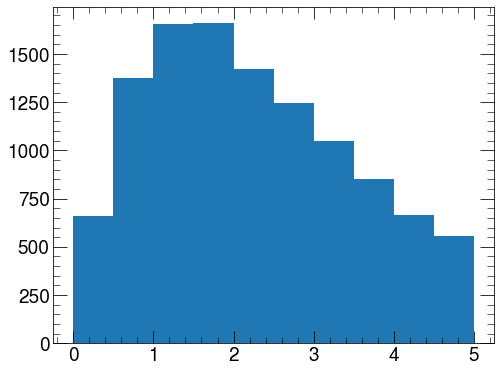

In [45]:
m =( df.ntag >=4) & ~df.pass_vbf_sel

Xwt_bins = np.append(np.linspace(0,5,11),np.inf)

plt.hist(df.loc[m,'X_wt_tag'],Xwt_bins,weights=df.loc[m,f'NN_{wl}_weight_bstrap_med_{yr}'])
plt.show()

In [44]:
np.append(np.linspace(0,5,11),np.inf)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , inf])

In [7]:
fDir = '../data/RR/cryptotuples/ggF_rw_pre_Xwt/'

figDir = 'figures/rings/'
outDir = '../stats-results/ttbar_eigen/'

### Get the enriched regions

**Note:**  Since Michael told me I can stll use the same enriched regions that I was using before (b/c I want to use as much information as I can), I should still be able to use the same `enrichedRegions` function

In [57]:
Xwt_bins = np.append(np.linspace(0,5,11),np.inf)

In [278]:
Xwt_bins

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , inf])

In [100]:
for yr, mc in zip(yrs,mcs):

    dat_name = f'{fDir}/data{yr}_NN_100_bootstraps.root'
    ah_name  = f'{fDir}/NanoNTuple_allhad_mc16{mc}_NN_100_bootstraps.root'
    sl_name  = f'{fDir}/NanoNTuple_semilep_mc16{mc}_NN_100_bootstraps.root'

    hist_dict = {}

    for fname,physSample,w,s,pre in zip([dat_name,ah_name,sl_name],['dat','ah','sl'],
                                        [None,'mc_sf','mc_sf'],[1,L[yr],L[yr]],['','mc_','mc_']):

        for tname, region in zip(['control','validation','sig'],['cr','vr','sr']):

            k = f'{physSample}_{region}'

            hist_dict[f'{k}_2b']   = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', w_col=w,scale=s,
                                                     Xwt_bins=Xwt_bins)
            hist_dict[f'{k}_{bcat}'] = enrichedRegions(fname, tname, bcat=bcat, w_col=w,scale=s,
                                                       Xwt_bins=Xwt_bins)
            hist_dict[f'{k}_rw_to_{bcat}'] = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', 
                                                             w_col=f'{pre}NN_{wl}_weight_bstrap_med_{yr}',
                                                             scale=s,Xwt_bins=Xwt_bins)

            hist_dict[f'{k}_rw_to_{bcat}_vr'] = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', 
                                                                w_col=f'{pre}NN_{wl}_weight_VRderiv_bstrap_med_{yr}',
                                                                scale=s,Xwt_bins=Xwt_bins)

    # Save the output histograms
    h_out = { k: v.tolist() for k,v in hist_dict.items() }
    with open(f'{outDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json','w') as fi:
        json.dump(h_out,fi)
        

### Do the 2-component fits

In [279]:
scaleAllHad2b=False

In [280]:
cov_dict = {}

In [281]:
for yr in [16,17,18]:
    
    # Load in the histograms which make the fit pieces
    with open(f'{outDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json') as fi:
        hist_dict = json.load(fi)
    
        for k in hist_dict.keys():
            hist_dict[k] = np.array(hist_dict[k])
    
    ps = {}
    
    for ri,ti in zip(['cr','vr'],['','_vr']):

        p, cov, alpha_2b = getFit(hist_dict,region=ri,target=bcat,train=ti)

        err = np.sqrt(np.diag(cov))
        
        sfs.loc[f'{ri.upper()} SF',yr] = [f'{pi:1.2f} $\pm$ {ei:1.2f}' for pi,ei in zip(p, err)]
        ps[ri] = p
        
        cov_dict[f'{yr}_{ri}'] = cov
        
    sfs.loc[f'extrap norm (new)',yr] = ps['vr'] / ps['cr']

In [284]:
# hist_dict

In [282]:
sfs

16                                    \
                          semi-lep          all-had              QCD   
CR SF              1.54 $\pm$ 0.17  1.61 $\pm$ 0.13  1.10 $\pm$ 0.02   
VR SF              1.63 $\pm$ 0.21  1.33 $\pm$ 0.13  1.12 $\pm$ 0.02   
extrap norm (new)         1.056634         0.824938         1.017873   

                                17                                    \
                          semi-lep          all-had              QCD   
CR SF              1.28 $\pm$ 0.12  1.98 $\pm$ 0.11  1.09 $\pm$ 0.01   
VR SF              1.12 $\pm$ 0.18  1.56 $\pm$ 0.11  1.15 $\pm$ 0.02   
extrap norm (new)         0.875017         0.785348         1.054802   

                                18                                    
                          semi-lep          all-had              QCD  
CR SF              1.06 $\pm$ 0.10  1.88 $\pm$ 0.08  1.07 $\pm$ 0.01  
VR SF              1.30 $\pm$ 0.14  1.34 $\pm$ 0.09  1.11 $\pm$ 0.02  
extrap norm (new)         1.221064         0.713425          1.03768

### Fill in the table and plot the correlation / covariance matrices

**Aside:** I'd _really_ like to have a HH diverging color map!!

In [122]:
scaleA

In [275]:
def fitCorrAllYrs(inDir='',figDir='',tag=''):

    l = [r'$t\bar{t}$','qcd']
    cmap = LinearSegmentedColormap.from_list("", ['hh:medturquoise','w','hh:darkpink'])

    fig, axes = plt.subplots(2,3,figsize=(12, 8), 
                         gridspec_kw={"height_ratios": [.5,.5],
                                      "width_ratios": [1/3,1/3,1/3],
                                      "wspace" : 0.4, 
                                     }
                        )
    
    for yr,ax_col in zip([16,17,18],axes.T):
    
        # Load in the histograms which make the fit pieces
        with open(f'{inDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json') as fi:
            hist_dict = json.load(fi)

            for k in hist_dict.keys():
                hist_dict[k] = np.array(hist_dict[k])
    
        for ri, ti,ax in zip(['cr','vr'],['','_vr'],ax_col):
            # Get the fits
            p_i, cov, alpha_2b_i = getFit(hist_dict,region=ri,target=bcat,train=ti,
                                          ttbar_inclusive=True,scaleAllHad2b=scaleAllHad2b)

            # Translate from covariance to correlation
            std = np.sqrt(np.diag(cov))
            den = np.array([[std[i] * std[j] for i in range(len(l))] for j in range(len(l))])
            
            corr = cov / den
            
            v_abs = np.max(np.abs(corr))
            im = ax.imshow(corr,cmap=cmap,vmin=-v_abs,vmax=v_abs)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax,ticks=[-1,0,1])

            ax.set_xticks(range(len(l)))
            ax.set_yticks(range(len(l)))
            ax.set_xticklabels(l,rotation=90*(1-1.2/len(l)))
            ax.set_yticklabels(l)

            # Step 3: Overlay the #s
            for i in range(len(l)):
                for j in range(len(l)):
                    cij = corr[i,j]

                    ax.text(i,j,f'{cij:.2f}',ha='center',va='center')

            ax.set_title(f'20{yr} {target_to_label[bcat]} {ri.upper()}',loc='left')
            ax.tick_params(which='minor', length=0)
            
    # Step 4: Save
    if figDir:
        print(f'{figDir}/fitCorr-{bcat}-CR-VR-16-17-18{tag}.pdf')
        plt.savefig(f'{figDir}/fitCorr-{bcat}-CR-VR-16-17-18{tag}.pdf', bbox_inches='tight')


In [274]:
tag

'_scaleAllHad2b'

figures/rings//fitCorr-4b-CR-VR-16-17-18_scaleAllHad2b.pdf


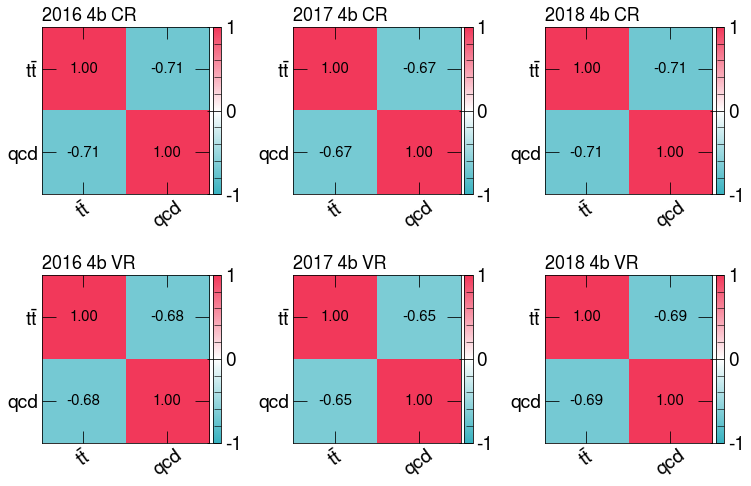

In [276]:
tag ='_scaleAllHad2b' if scaleAllHad2b else ''
fitCorrAllYrs(outDir,figDir=figDir,tag=tag)

In [213]:
from matplotlib.ticker import Locator

In [246]:
?plt.subplots

In [270]:
def fitsAllYrs(inDir,region='cr',target='3b1f',train='',Xwt_bins=Xwt_bins,
               rlim1=(.9,1.1),rlim2=(.9,1.1),show_rw=False,figDir='',tag=''):
    '''
    Compare the pre and post-fit ttbar yields plots for all of the years
    '''
    
    lw=2.5
    labels = [r'semi-lep $t\bar{t}$',r'all-had $t\bar{t}$','qcd est']
    colors = ['hh:lightturquoise','hh:darkgreen','hh:darkyellow']
    
    fig, axes = plt.subplots(4,3,figsize=(18, 12), #sharex=True,
                             gridspec_kw={"height_ratios": [1/3,1/6,1/3,1/6],
                                          "width_ratios": [1/3,1/3,1/3],
                                          "wspace" : 0.25, "hspace":0.25,
                                          "left":0.1, "bottom":.25}
                            )
    
    for yr,ax_col in zip([16,17,18],axes.T):
    
        # Load in the histograms which make the fit pieces
        with open(f'{inDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json') as fi:
            hist_dict = json.load(fi)

            for k in hist_dict.keys():
                hist_dict[k] = np.array(hist_dict[k])
    
        # Get the fits
        p_i, cov_i, alpha_2b_i = getFit(hist_dict,region,target,train,
                                        ttbar_inclusive=True,scaleAllHad2b=scaleAllHad2b)

        u,V = np.linalg.eig(cov_i)
        
        keys = [f'sl_{region}_{target}',f'ah_{region}_{target}',f'qcd_{region}_rw_to_{target}{train}']
        hist_comp = np.vstack([hist_dict[keys[0]]+hist_dict[keys[1]], hist_dict[keys[2]]])
        
        err = np.sqrt(np.sum((np.sqrt(u.reshape(-1,1)) * np.matmul(V.T,hist_comp))**2,axis=0))
        
        #err = np.sqrt(np.diag(cov_i))
    
        hists = [hist_dict[k] for k in keys]

        p_samples = np.array([p_i[0],p_i[0],p_i[1]])
        
        for p,opt,rlim,ax1,ax2 in zip([np.ones(3),p_samples],['pre','post'],[rlim1,rlim2],
                                      [ax_col[0],ax_col[2]],[ax_col[1],ax_col[3]]):
            
            prev = 0
            
            Xwt_edg = np.concatenate([[-2], Xwt_bins])
            Xwt_mid = 0.5 * (Xwt_edg[1:] + Xwt_edg[:-1])
            widths  = 0.5 * (Xwt_edg[1:] - Xwt_edg[:-1])
            
            
            for h,pi,c,l in zip(hists,p,colors,labels):

                ax1.hist(Xwt_mid, Xwt_edg, weights=pi*h,bottom=prev,color=c,label=l)
                prev+=pi*h

            y = hist_dict[f'dat_{region}_{target}']
            ax1.errorbar(Xwt_mid,y,np.sqrt(y),widths,lw=0,elinewidth=lw,
                           color='k',marker='o',label=target_to_label[target])

            # And the ratio panel
            pred = np.vstack(p.reshape(-1,1)*hists).sum(axis=0)

            ax2.errorbar(Xwt_mid,y/pred, np.sqrt(y)/pred,widths,
                         lw=0,elinewidth=lw,color='k',marker='o')

            if show_rw:
                rw = hist_dict[f'dat_{region}_rw_to_{target}']
                ax1.plot(Xwt_mid,rw,color='hh:darkpink',lw=0,marker='s')
                ax2.plot(Xwt_mid,rw/pred,color='hh:darkpink',lw=0,marker='s')

                
            if opt=='post':
                # Hatched line for the error on the prediction
                ax2.fill_between(Xwt_edg,np.append(0,1-err/pred), np.append(0,1+err/pred),step="pre", 
                                   facecolor='None',edgecolor='dimgrey', hatch='\\\\\\\\',lw=0)            

            ax1.text(.95,.9,f'20{yr} {region.upper()}\n{opt}-fit',transform=ax1.transAxes,
                     ha='right',va='top',fontsize=17)

            ax1.set_ylabel('Entries',ha='right',y=1,fontsize=15)
            ax2.set_ylabel(f'{target} / pred',fontsize=15)

            ax1.legend(fontsize=12)
            
            # Draw the Xwt cut that we'll apply
            ylim = ax1.get_ylim()
            ax1.plot([1.5]*2,ylim,color='hh:darkpink',ls='--',lw=lw)
               
            for ax in [ax1,ax2]: 
                ax.set_xticks(range(-1,5))
                ax.set_xlim(-2,5)
                ax.set_xticklabels(['iso $\mu$']+[f'{i}' for i in range(5)])
                
            ax2.plot(Xwt_edg,np.ones_like(Xwt_edg),'k',ls='dotted',lw=lw)
            ax2.set_ylim(rlim)
            ax2.set_xlabel('$X_{Wt}$',ha='right',x=1,labelpad=-15)
    
    if figDir:
        plt.savefig(f'{figDir}/prePostFit-{region}-16-17-18_{bcat}_{len(Xwt_bins)}_Xwt_bins{tag}.pdf', bbox_inches='tight')


In [271]:
fitsAllYrs(outDir,target=bcat,rlim1=(0,2),rlim2=(.7,1.3),figDir=figDir,tag=tag)

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)
/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]
/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)
/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]
/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value enco